In [3]:
# Import necessary libraries
import pandas as pd
import plotly.graph_objects as go
import dalmatian
from google.cloud import storage
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

import numpy as np

from plotly.subplots import make_subplots
from fludarabine import model_helper 
from fludarabine.helper import *

In [4]:
def create_html_file(plot_html_list, output_file="combined_plots.html"):
    """
    Combines multiple Plotly plots into a single HTML file.

    Parameters:
    - plot_html_list: List of HTML content for each plot.
    - output_file: Name of the output HTML file.
    """
    # Start the HTML content
    html_content = """
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Combined Plots</title>
        <style>
            .plot-container {
                margin-bottom: 40px;
            }
        </style>
    </head>
    <body>
        <h1>Combined Plots</h1>
    """

    # Add each plot to the HTML content
    for plot_html in plot_html_list:
        html_content += f"""
        <div class="plot-container">
            {plot_html}
        </div>
        """

    # Close the HTML content
    html_content += """
    </body>
    </html>
    """

    # Write the HTML content to a file
    with open(output_file, "w") as f:
        f.write(html_content)

    print(f"HTML file saved as {output_file}")

In [5]:


# Function to load data
def load_data(patient_id, wbc_file, treatment_file):
    # Load WBC and treatment data
    wbc_df = pd.read_csv(wbc_file)
    treatment_df = pd.read_csv(treatment_file, sep='\t')
    
    # Get input files from Terra through dalmatian
    workspace = 'broad-firecloud-ibmwatson/TAG_CLL_Clonal_Kinetic_UMI_PrAN'
    wm = dalmatian.WorkspaceManager(workspace)
    participants = wm.get_participants()
    
    # Load additional data for the patient
    cluster_CCF_df = pd.read_csv(participants.loc[patient_id]['cluster_ccfs'], sep='\t')
    abundance_df = pd.read_csv(participants.loc[patient_id]['abundances_tsv'], sep='\t')
    mcmc_df = pd.read_csv(participants.loc[patient_id]['cell_population_mcmc_trace'], sep='\t')
    tree_df = pd.read_csv(participants.loc[patient_id]['tree_tsv'], sep='\t')
    
    return wbc_df, treatment_df, cluster_CCF_df, abundance_df, mcmc_df, tree_df

# Function to filter data for a specific patient
def filter_patient_data(wbc_df, patient_id):
    wbc_df_patient = wbc_df[wbc_df['Patient'] == patient_id]
    wbc_df_patient.reset_index(drop=True, inplace=True)
    sample_list = wbc_df_patient['Timepoint'].dropna().tolist()
    times_sample = [int(i) for i in wbc_df_patient.loc[wbc_df_patient.Sample.notna(), 'Time_since_start_tx'].tolist()]
    CLL_count = [float(i) for i in wbc_df_patient.loc[wbc_df_patient.Sample.notna(), 'CLL count estm'].tolist()]
    all_times = [int(i) for i in wbc_df_patient['Time_since_start_tx'].to_list()]
    
    return wbc_df_patient, sample_list, times_sample, CLL_count, all_times

# Function to create an interactive plot and save it as HTML
def plot_CLL_count(times_sample, CLL_count, UMI_start, UMI_end, treatment_start, treatment_end,):
    # Create the plot
    fig = go.Figure()

    # Add the main CLL count line
    fig.add_trace(go.Scatter(
        x=times_sample, 
        y=CLL_count, 
        mode='lines+markers', 
        name='CLL Count',
        line=dict(color='blue')
    ))

    # Highlight UMI timepoints
    fig.add_trace(go.Scatter(
        x=times_sample[UMI_start:UMI_end], 
        y=CLL_count[UMI_start:UMI_end], 
        mode='markers', 
        name='UMI Timepoints',
        marker=dict(color='red', size=10, symbol='circle')
    ))

    # Add a shaded region for the treatment period
    fig.add_vrect(
        x0=treatment_start, 
        x1=treatment_end, 
        fillcolor="lightgray", 
        opacity=0.5, 
        layer="below", 
        line_width=0,
        annotation_text="Fludarabine Treatment", 
        annotation_position="top left"
    )

    # Customize the layout
    fig.update_layout(
        title=f'CLL Count Over Time for Patient {patient_id}',
        xaxis_title='Days from Diagnosis',
        yaxis_title='CLL Count (log scale)',
        yaxis_type="log",
        showlegend=True,
        template="plotly_white"
    )

    # Return html content 
    return fig.to_html(full_html=False)
    



In [6]:
# Input patient information
patient_id = 'GCLL-0068'
wbc_file = '../../../data/gcll/CLL8 CLL cell count 10282024 UPDATED.csv'
treatment_file = "../../../data/gcll/GCLL_treatment.txt"
UMI_start = 1
UMI_end = 4
treatment_start = 0
treatment_end = 143

In [7]:

wbc_df, treatment_df, cluster_CCF_df, abundance_df, mcmc_df, tree_df = load_data(patient_id, wbc_file, treatment_file)

# Filter data for the specific patient
wbc_df_patient, sample_list, times_sample, CLL_count, all_times = filter_patient_data(wbc_df, patient_id)

# Plot CLL count over time and save as HTML
CLL_plot_html = plot_CLL_count(times_sample, CLL_count, UMI_start, UMI_end, treatment_start, treatment_end, )
    




In [8]:
tree_df

,n_iter,likelihood,edges
0,78,"[0.25000000000000006, 0.25000000000000006, 0.2...","1-2,2-3,2-4,None-1"
1,53,"[0.25, 0.24999999999999994, 0.2499999999999999...","1-2,1-4,2-3,None-1"
2,49,"[0.24999999999999994, 0.24999999999999994, 0.3...","1-2,1-3,2-4,None-1"
3,42,"[0.24999999999999994, 0.24999999999999994, 0.2...","1-2,2-3,3-4,None-1"
4,27,"[0.3333333333333334, 0.3333333333333333, 0.333...","1-2,1-3,3-4,None-1"


In [9]:
tree_df.to_csv('tree_0068.csv')

In [10]:
def plot_tree(tree_df, tree_selected, ax, edge_labels =None):
    edges = tree_df.loc[tree_selected, 'edges'].split(',')
    cluster_list = []
    for i in edges:
        new_list = i.split('-')
        for j in new_list:
            if (j !='None') & (j not in cluster_list):
                cluster_list.append(j)
    cluster_list = [int(i) for i in cluster_list]
    
    
    DG=nx.DiGraph() 
    for edge in edges:
        nodes = edge.split('-')
        if nodes[0]!='None':
            DG.add_edge(int(nodes[0]), int(nodes[1]))
            
    pos=graphviz_layout(DG,  prog='dot')
    
    edge_color_list=[]
    for edge in DG.edges():
        node=edge[1]

        edge_color_list.append(ClusterColors.get_hex_string(node) )
        
    nx.draw(DG,pos, with_labels = True, width = 4, node_size= 400, ax =ax, arrows= False, font_color='white',edge_color = edge_color_list, node_color =[ClusterColors.get_hex_string(i) for i in cluster_list] )
    if edge_labels:
        nx.draw_networkx_edge_labels(DG, pos,
        edge_labels,
        font_color=ClusterColors.get_hex_string(7))

    return DG

FileNotFoundError: [Errno 2] "dot" not found in path.

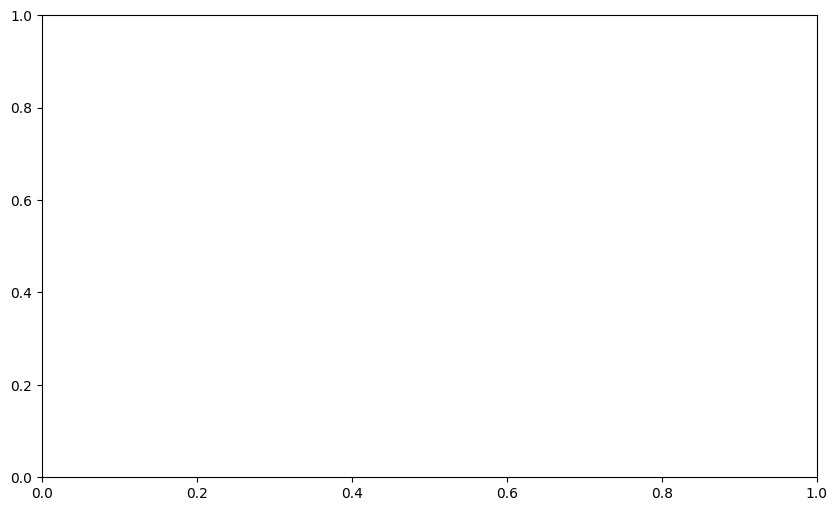

In [11]:
fig, ax = plt.subplots(figsize = (10, 6))
plot_tree(tree_df, tree_selected = 0,ax = ax, )

In [12]:
def plot_data_table(df, ):
    # Create a Plotly table
    table = go.Table(
        header=dict(
            values=list(df.columns),  # Column names
            fill_color='lightblue',   # Header background color
            align='left'              # Align text to the left
        ),
        cells=dict(
            values=[df[col] for col in df.columns],  # Cell values
            fill_color='white',                      # Cell background color
            align='left'                             # Align text to the left
        )
    )

    # Create a figure and add the table
    fig = go.Figure(data=[table])

    # Update layout for better appearance
    fig.update_layout(
        title=f'Patient ID:{patient_id}',
        title_x=0.5,  # Center the title
        margin=dict(l=20, r=20, t=40, b=20)  # Adjust margins
    )

    return fig.to_html(full_html=False)

In [13]:
wbc_table_html = plot_data_table(wbc_df_patient, )

In [14]:
def plot_ccf(df, times_sample, treatment_df,):
    """
    Plots the CCF (Cancer Cell Fraction) data using Plotly.

    Parameters:
    - df: DataFrame containing CCF data.
    - fig: Plotly figure object.
    - row: Row position of the subplot.
    - col: Column position of the subplot.
    - times_sample: List of sample times.
    - treatment: DataFrame containing treatment information.
    - ClusterColors: Object to map cluster IDs to colors.
    """
    
    
    fig = go.Figure()
    # Keep the necessary columns
    cols = ['Sample_ID', 'Cluster_ID', 'postDP_ccf_mean', 'postDP_ccf_CI_low', 'postDP_ccf_CI_high']
    df = df[cols]
    cluster_list = df.Cluster_ID.unique().tolist()
    number_samples = len(df.Sample_ID.unique())

    # Create tick labels
    tick_list = ['T' + str(i) for i in range(number_samples)]
    x_axis = [i / 365 for i in times_sample]

    # Plot each cluster
    for cluster in cluster_list:
        cluster_data = df[df.Cluster_ID == cluster]
        y_mean = cluster_data.postDP_ccf_mean
        y_ci_low = cluster_data.postDP_ccf_CI_low
        y_ci_high = cluster_data.postDP_ccf_CI_high

        # Plot mean CCF
        fig.add_trace(
            go.Scatter(
                x=x_axis,
                y=y_mean,
                mode='lines+markers',
                line=dict(color=ClusterColors.get_hex_string(cluster)),
                marker=dict(color=ClusterColors.get_hex_string(cluster)),
                name=f'Cluster {cluster}',
                legendgroup=f'Cluster {cluster}'
            ),

        )

        # Plot confidence interval
        fig.add_trace(
            go.Scatter(
                x=x_axis,
                y=y_ci_high,
                mode='lines',
                line=dict(width=0),
                fillcolor=ClusterColors.get_hex_string(cluster),
                fill='tonexty',
                opacity = 0.1,
                showlegend=False,
                legendgroup=f'Cluster {cluster}'
            ),
       
        )
        fig.add_trace(
            go.Scatter(
                x=x_axis,
                y=y_ci_low,
                mode='lines',
                line=dict(width=0),
                fillcolor=ClusterColors.get_hex_string(cluster),
                fill='tonexty',
                opacity = 0.1,
                showlegend=False,
                legendgroup=f'Cluster {cluster}'
            ),
        
        )

    # Add treatment information
    for i, row_data in treatment_df.iterrows():
        treatment_name = row_data.tx
        start = row_data.tx_start / 365
        end = row_data.tx_end / 365 if not np.isnan(row_data.tx_end) else max(x_axis)
        fig.add_vrect(
            x0=start, x1=end,
            fillcolor="lightgray", opacity=0.2,
            layer="below", line_width=0,
            annotation_text=treatment_name, annotation_position="top left"
        )

    # Set axis labels and grid
    fig.update_xaxes(title_text="Samples", )
    fig.update_yaxes(title_text="CCF",)
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray', )
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray',)

#     # Add secondary x-axis for time in years
#     fig.update_xaxes(
#         title_text="Time (years)",
        
#         secondary_y=False,
#         overlaying="x",
#         side="top"
        
        
    
#     )
    # Return html content 
    return fig.to_html(full_html=False)

In [15]:
 plot_ccf_html = plot_ccf(cluster_CCF_df, times_sample, treatment_df,)

In [16]:

def plot_subclones(clusters, times_sample, CLL_count, log_subclone_sample, extrapolate_start_idx, times_aft_tx, treatment, ):
    """
    Plot subclones and extrapolate their behavior after treatment using Plotly.

    Args:
        clusters (list): List of cluster IDs to plot.
        times_sample (list): List of timepoints since treatment start.
        CLL_count (list): List of CLL count estimates.
        log_subclone_sample (dict): Dictionary of log subclone counts for each cluster.
        extrapolate_start_idx (int): Index to start extrapolation.
        times_aft_tx (list): Timepoints after treatment for extrapolation.
        treatment (pd.DataFrame): Treatment data.
        ClusterColors: Object to get cluster colors.
    """
    # Create a subplot with two rows
    fig = go.Figure()

    # Plot total WBC
    x_year = [i / 365 for i in np.array(times_sample)]
    fig.add_trace(
        go.Scatter(x=x_year, y=np.log(CLL_count), mode='markers', name='CLL count estimate', marker=dict(color='red')),
        
    )

    # Plot subclones and extrapolate after treatment
    predicted_end_tx_clones = []
    for i in clusters:
        y_sub = np.array(log_subclone_sample[i])
        fig.add_trace(
            go.Scatter(x=x_year, y=y_sub, mode='markers', name=f'Cluster {i}', marker=dict(color=ClusterColors.get_hex_string(i))),
           
        )

        # Extrapolate after treatment
        extrapolate_times = times_sample[extrapolate_start_idx:]
        extrapolate_year = [i / 365 for i in np.array(extrapolate_times)]
        extrapolate_subclone = log_subclone_sample[i][extrapolate_start_idx:]

        # Fit a linear model for extrapolation
        linear_model = np.polyfit(extrapolate_year, extrapolate_subclone, 1)
        predict_year = [i / 365 for i in np.array(times_aft_tx)]
        predicted = np.polyval(linear_model, predict_year)
        predicted_end_tx_clones.append(predicted[0])

        # Plot the extrapolated line
        fig.add_trace(
            go.Scatter(x=predict_year, y=predicted, mode='lines', name=f'Cluster {i} (extrapolated)', line=dict(color=ClusterColors.get_hex_string(i))),
            
        )

    # Plot treatment effects
    times_during_tx = [0, 143 / 365]
    tx_start_clones = [log_subclone_sample[i][0] for i in clusters]

    for i in clusters:
        fig.add_trace(
            go.Scatter(x=times_during_tx, y=[tx_start_clones[i - 1], predicted_end_tx_clones[i - 1]], mode='lines+markers', name=f'Cluster {i} (treatment)', line=dict(color=ClusterColors.get_hex_string(i))),
          
        )

    # Add treatment annotations
    for i, row in treatment_df.iterrows():
        treatment_name = row.tx
        start = row.tx_start / 365
        end = row.tx_end / 365
        fig.add_vrect(x0=start, x1=end, fillcolor="lightgray", opacity=0.5, line_width=0, annotation_text=treatment_name, annotation_position="top left", )

    # Update layout
    fig.update_layout(
        title="CLL Count and Subclones with Treatment Effects",
        xaxis_title="Time (years)",
        yaxis_title="log CLL count estimates",

        showlegend=True,
        height=800,
    )

    # Return HTML content
    return fig.to_html(full_html=False)
    


   

In [17]:
abundance_df.Sample_ID.unique()

array(['GCLL-0068-T-01',
       'RP-1895_PDO-33508_SM-NKK1G_GCLL-0068-MRD-01_v1_Custom_Selection_OnPrem',
       'RP-1895_PDO-33508_SM-NKK12_GCLL-0068-MRD-03_v1_Custom_Selection_OnPrem',
       'RP-1895_PDO-33508_SM-NKK1P_GCLL-0068-MRD-02_v1_Custom_Selection_OnPrem',
       'GCLL-0068-T-02'], dtype=object)

In [18]:
# Manually verify the sample list order is correct

In [19]:
sample_list = ['GCLL-0068-T-01','RP-1895_PDO-33508_SM-NKK1G_GCLL-0068-MRD-01_v1_Custom_Selection_OnPrem','RP-1895_PDO-33508_SM-NKK1P_GCLL-0068-MRD-02_v1_Custom_Selection_OnPrem',
               'RP-1895_PDO-33508_SM-NKK12_GCLL-0068-MRD-03_v1_Custom_Selection_OnPrem',
 'GCLL-0068-T-02']

In [20]:
cluster_list, cluster_abundance = model_helper.get_abundance(abundance_df, mcmc_df, sample_list)
subclone_sample, log_subclone_sample = model_helper.calc_subclone(CLL_count, cluster_abundance, cluster_list)
all_abundance = model_helper.get_all_abundance(cluster_list, mcmc_df, sample_list, times_sample, )

In [21]:
#  Add noise to all abundance

import random 

def add_uniform_noise_and_normalize(lst, low=0, high=0.01):
    
    # Add uniform noise
    noisy_lst = [x + random.uniform(low, high) for x in lst]

    
    # Normalize the list
    total_sum = sum(noisy_lst)
    
    normalized_lst = [x / total_sum for x in noisy_lst]

    return normalized_lst


subclone_cluster_iter = {}
# Iterate through each cluster
for cluster, iterations in all_abundance.items():
   
    # Iterate through each iteration in the cluster
    for iteration, value in iterations.items():
        # If the iteration is not in the new dict, add it
        if iteration not in subclone_cluster_iter:
            subclone_cluster_iter[iteration] = {}
        # Add the cluster and its value to this iteration
        subclone_cluster_iter[iteration][cluster] = value

        
        
noise_added_iter = {}

for iteration, abundances in subclone_cluster_iter.items():
    
    transposed_data = {i: list(values) for i, values in enumerate(zip(*abundances.values()), start=1)}
    
    noise_added_iter[iteration] = {}
    for time_point, abundance in transposed_data.items():
        
#         print(time_point, abundance)
        noise_abundance = add_uniform_noise_and_normalize(abundance)
    
#         print(noise_abundance)

        noise_added_iter[iteration][time_point] = add_uniform_noise_and_normalize(abundance)

    
noise_added_all_abundance = {}
for iteration, abundances in noise_added_iter.items():
    original_format = {i + 1: list(values) for i, values in enumerate(zip(*abundances.values()))}
    noise_added_all_abundance[iteration] = original_format
    
    
noise_added_original_all_abundances = {}

for iteration, abundances in noise_added_all_abundance.items():
    
    for cluster, abundance_value in abundances.items():
        if cluster not in noise_added_original_all_abundances:
            noise_added_original_all_abundances[cluster] = {}
        noise_added_original_all_abundances[cluster][iteration] = abundance_value
            

In [22]:
subclone_sample_mcmc_with_uniform_noise, log_subclone_sample_mcmc_with_uniform_noise = model_helper.calc_subclone(CLL_count, noise_added_original_all_abundances, cluster_list, input_type = "mcmc")

In [23]:
times_aft_tx = [x for x in all_times if x > 143]
times_aft_tx.insert(0, 143)

# Set the extrapolate time after treatment
extrapolate_start_idx = 1

In [24]:
# Generate Plotly plot
subclone_plot_html = plot_subclones(cluster_list, times_sample, CLL_count, log_subclone_sample, extrapolate_start_idx, times_aft_tx, treatment_df, )


In [25]:
create_html_file([wbc_table_html, plot_ccf_html, CLL_plot_html, subclone_plot_html], output_file="CLL_subplot_combined.html")

HTML file saved as CLL_subplot_combined.html


In [1]:
def plot_linear_model_mcmc(clusters):
    """
    Plots subclones with MCMC data for all clusters using Plotly.
    Includes both growth rate and decay rate histograms and tables.

    Parameters:
    - clusters: List of cluster IDs to plot.
    """
    num_clusters = len(clusters)
    # Calculate rows needed:
    # - One row per pair of clusters
    # - One row for histograms
    # - Two rows for tables (one for growth, one for decay)
    num_rows = ((num_clusters + 1) // 2) + 3  # +3 for histograms and tables
    num_cols = 2
    
    # Define subplot specs
    specs = []
    # Add rows for cluster plots
    for _ in range((num_clusters + 1) // 2):
        specs.append([{'type': 'xy'}, {'type': 'xy'}])
    # Add row for histograms
    specs.append([{'type': 'xy'}, {'type': 'xy'}])
    # Add rows for tables
    specs.append([{'type': 'table', 'colspan': 2}, None])  # Growth table
    specs.append([{'type': 'table', 'colspan': 2}, None])  # Decay table
    
    # Create subplots with appropriate titles
    subplot_titles = [f'Cluster {cluster}' for cluster in clusters]
    subplot_titles.extend(['Growth Rate Histogram', 'Decay Rate Histogram'])
    
    fig = make_subplots(
        rows=num_rows, cols=num_cols,
        subplot_titles=subplot_titles,
        vertical_spacing=0.1,
        specs=specs,
        row_heights=[1]*((num_clusters + 1) // 2) + [1, 0.5, 0.5]  # Adjust table row heights
    )

    # Plot subclones for each cluster
    slopes_mcmc = {}
    slopes_mcmc_decay = {}
    for idx, cluster in enumerate(clusters):
        row = (idx // 2) + 1
        col = (idx % 2) + 1

        # Plot total WBC
        x_year = [i / 365 for i in times_sample]
        fig.add_trace(
            go.Scatter(
                x=x_year,
                y=np.log(CLL_count),
                mode='markers',
                marker=dict(color='red'),
                name='CLL count estimate'
            ),
            row=row, col=col
        )

        # Plot subclones and extrapolate
        slopes_mcmc[cluster] = []
        slopes_mcmc_decay[cluster] = []
        for iter_idx in range(250):
            y_sub = log_subclone_sample_mcmc_with_uniform_noise[cluster][iter_idx]
            fig.add_trace(
                go.Scatter(
                    x=x_year,
                    y=y_sub,
                    mode='markers',
                    marker=dict(color=ClusterColors.get_hex_string(cluster)),
                    showlegend=False
                ),
                row=row, col=col
            )

            # Extrapolate after treatment
            extrapolate_times = times_sample[extrapolate_start_idx:]
            extrapolate_year = [i / 365 for i in extrapolate_times]
            extrapolate_subclone = y_sub[extrapolate_start_idx:]
            linear_model = np.polyfit(extrapolate_year, extrapolate_subclone, 1)
            slopes_mcmc[cluster].append(linear_model[0])

            predict_year = [i / 365 for i in times_aft_tx]
            predicted = np.polyval(linear_model, predict_year)
            
            # Calculate decay rate 
            slope_decay = (predicted[0] - y_sub[0]) / (143 / 365)
            slopes_mcmc_decay[cluster].append(slope_decay)
            
            fig.add_trace(
                go.Scatter(
                    x=predict_year,
                    y=predicted,
                    mode='lines',
                    line=dict(color=ClusterColors.get_hex_string(cluster)),
                    showlegend=False
                ),
                row=row, col=col
            )

            # Plot during treatment
            times_during_tx = [0, 143 / 365]
            tx_start_clones = y_sub[0]
            fig.add_trace(
                go.Scatter(
                    x=times_during_tx,
                    y=[tx_start_clones, predicted[0]],
                    mode='lines+markers',
                    line=dict(color=ClusterColors.get_hex_string(cluster)),
                    marker=dict(color=ClusterColors.get_hex_string(cluster)),
                    showlegend=False
                ),
                row=row, col=col
            )

        # Add treatment information
        for i, row_data in treatment_df.iterrows():
            treatment_name = row_data.tx
            start = row_data.tx_start / 365
            end = row_data.tx_end / 365 if not np.isnan(row_data.tx_end) else max(x_year)
            fig.add_vrect(
                x0=start, x1=end,
                fillcolor="gray", opacity=0.5,
                layer="below", line_width=0,
                annotation_text=treatment_name, annotation_position="top left",
                row=row, col=col
            )

        # Set axis labels
        fig.update_xaxes(title_text="Time (years)", row=row, col=col)
        fig.update_yaxes(title_text="log CLL count estimates (×10^6 cells/ml)", row=row, col=col)
        fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray', row=row, col=col)
        fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray', row=row, col=col)

    # Plot growth rate histogram (second last row)
    row_hist = num_rows - 2
    for cluster in clusters:
        fig.add_trace(
            go.Histogram(
                x=slopes_mcmc[cluster],
                name=f'Cluster {cluster} Growth',
                marker_color=ClusterColors.get_hex_string(cluster),
                opacity=0.5
            ),
            row=row_hist, col=1
        )
    fig.update_xaxes(title_text="Growth Rate (slope)", row=row_hist, col=1)
    fig.update_yaxes(title_text="Count", row=row_hist, col=1)
        
    # Plot decay rate histogram (second last row, second column)
    for cluster in clusters:
        fig.add_trace(
            go.Histogram(
                x=slopes_mcmc_decay[cluster],
                name=f'Cluster {cluster} Decay',
                marker_color=ClusterColors.get_hex_string(cluster),
                opacity=0.5
            ),
            row=row_hist, col=2
        )
    fig.update_xaxes(title_text="Decay Rate (slope)", row=row_hist, col=2)
    fig.update_yaxes(title_text="Count", row=row_hist, col=2)

    # Calculate stats for growth rates
    table_data_growth = []
    for cluster in clusters:
        mean = np.mean(slopes_mcmc[cluster], axis=0)
        lower_ci = np.percentile(slopes_mcmc[cluster], 2.5, axis=0)
        upper_ci = np.percentile(slopes_mcmc[cluster], 97.5, axis=0)
        table_data_growth.append([f'Cluster {cluster}', f'{mean:.4f}', f'{lower_ci:.4f} to {upper_ci:.4f}'])
        
    # Calculate stats for decay rates
    table_data_decay = []
    for cluster in clusters:
        mean_decay = np.mean(slopes_mcmc_decay[cluster], axis=0)
        lower_ci_decay = np.percentile(slopes_mcmc_decay[cluster], 2.5, axis=0)
        upper_ci_decay = np.percentile(slopes_mcmc_decay[cluster], 97.5, axis=0)
        table_data_decay.append([f'Cluster {cluster}', f'{mean_decay:.4f}', f'{lower_ci_decay:.4f} to {upper_ci_decay:.4f}'])

    # Add growth rate table (second last row)
    fig.add_trace(
        go.Table(
            header=dict(
                values=['Cluster', 'Mean Growth Rate', '95% CI'],
                fill_color='lightblue',
                align='left'
            ),
            cells=dict(
                values=list(zip(*table_data_growth)),
                fill_color='white',
                align='left'
            )
        ),
        row=num_rows-1, col=1
    )
    
    # Add decay rate table (last row)
    fig.add_trace(
        go.Table(
            header=dict(
                values=['Cluster', 'Mean Decay Rate', '95% CI'],
                fill_color='lightgreen',
                align='left'
            ),
            cells=dict(
                values=list(zip(*table_data_decay)),
                fill_color='white',
                align='left'
            )
        ),
        row=num_rows, col = 1)
    
    
    
    # Update layout
    fig.update_layout(
        title="CLL Subclone Analysis",
        showlegend=True,
        height=400 * num_rows,  # Adjust height based on the number of rows
        width=1200
    )

    print(slopes_mcmc_decay)
    # Return HTML content
    return fig.to_html(full_html=False)

In [55]:
def plot_linear_model_mcmc( clusters, ):
    """
    Plots subclones with MCMC data for all clusters using Plotly.

    Parameters:
    - fig: Plotly figure object.
    - clusters: List of cluster IDs to plot.
    - start_row: Starting row position for the subplots.
    - start_col: Starting column position for the subplots.
    """


    # Determine the number of rows and columns
    num_clusters = len(clusters)
    num_rows = (num_clusters // 2) + 2  # Ensure enough rows for clusters and histogram
    num_cols = 2  # Two columns for clusters and histogram
    
    # Define subplot specs
    specs = [[{'type': 'xy'}, {'type': 'xy'}]] * (num_rows - 1) + [[{'type': 'table', 'colspan': 2}, None]]
    
     # Create subplots
    fig = make_subplots(
        rows=num_rows, cols=num_cols,
        subplot_titles=[f'Cluster {cluster}' for cluster in clusters] + ['Slopes Histogram'],
        vertical_spacing=0.1,
        specs=specs
    )

    # Plot subclones for each cluster
    slopes_mcmc = {}
    slopes_mcmc_decay = {}
    for idx, cluster in enumerate(clusters):
        row = (idx // 2) + 1  # Determine row position
        col = (idx % 2) + 1  # Determine column position

        # Plot total WBC
        x_year = [i / 365 for i in times_sample]
        fig.add_trace(
            go.Scatter(
                x=x_year,
                y=np.log(CLL_count),
                mode='markers',
                marker=dict(color='red'),
                name='CLL count estimate'
            ),
            row=row, col=col
        )

        # Plot subclones and extrapolate
        slopes_mcmc[cluster] = []
        slopes_mcmc_decay[cluster] = []
        for iter_idx in range(250):
            y_sub = log_subclone_sample_mcmc_with_uniform_noise[cluster][iter_idx]
            fig.add_trace(
                go.Scatter(
                    x=x_year,
                    y=y_sub,
                    mode='markers',
                    marker=dict(color=ClusterColors.get_hex_string(cluster)),
                    showlegend=False
                ),
                row=row, col=col
            )

            # Extrapolate after treatment
            extrapolate_times = times_sample[extrapolate_start_idx:]
            extrapolate_year = [i / 365 for i in extrapolate_times]
            extrapolate_subclone = y_sub[extrapolate_start_idx:]
            linear_model = np.polyfit(extrapolate_year, extrapolate_subclone, 1)
            slopes_mcmc[cluster].append(linear_model[0])

            predict_year = [i / 365 for i in times_aft_tx]
            predicted = np.polyval(linear_model, predict_year)
            
            
            # Add decay rate 
            
            slope_decay = (predicted[0] - y_sub[0]) / (143 / 365)
            slopes_mcmc_decay[cluster].append(slope_decay)
            
            
            fig.add_trace(
                go.Scatter(
                    x=predict_year,
                    y=predicted,
                    mode='lines',
                    line=dict(color=ClusterColors.get_hex_string(cluster)),
                    showlegend=False
                ),
                row=row, col=col
            )

            # Plot during treatment
            times_during_tx = [0, 143 / 365]
            tx_start_clones = y_sub[0]
            fig.add_trace(
                go.Scatter(
                    x=times_during_tx,
                    y=[tx_start_clones, predicted[0]],
                    mode='lines+markers',
                    line=dict(color=ClusterColors.get_hex_string(cluster)),
                    marker=dict(color=ClusterColors.get_hex_string(cluster)),
                    showlegend=False
                ),
                row=row, col=col
            )

        # Add treatment information
        for i, row_data in treatment_df.iterrows():
            treatment_name = row_data.tx
            start = row_data.tx_start / 365
            end = row_data.tx_end / 365 if not np.isnan(row_data.tx_end) else max(x_year)
            fig.add_vrect(
                x0=start, x1=end,
                fillcolor="gray", opacity=0.5,
                layer="below", line_width=0,
                annotation_text=treatment_name, annotation_position="top left",
                row=row, col=col
            )

        # Set axis labels and grid
        fig.update_xaxes(title_text="Samples", row=row, col=col)
        fig.update_yaxes(title_text="log CLL count estimates (×10^6 cells/ml)", row=row, col=col)
        fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray', row=row, col=col)
        fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray', row=row, col=col)

#         # Add secondary x-axis for time in years
#         fig.update_xaxes(
#             title_text="Time (years)",
#             row=row, col=col,
#             secondary_y=False,
#             overlaying="x",
#             side="top"
#         )

    # Plot slopes histogram in the last subplot
    row_hist = num_rows -1
    col_hist = 1 if num_clusters % 2 == 1 else 2  # Place histogram in the last available position
    for cluster in clusters:
        fig.add_trace(
            go.Histogram(
                x=slopes_mcmc[cluster],
                name=f'Cluster {cluster}',
                marker_color=ClusterColors.get_hex_string(cluster),
                opacity=0.5
            ),
            row=row_hist, col=col_hist
        )
        
        
    # Plot slopes histogram for the decay rate in the last subplot
    row_hist = num_rows -1
    col_hist = 1 if num_clusters % 2 == 1 else 2  # Place histogram in the last available position
    for cluster in clusters:
        fig.add_trace(
            go.Histogram(
                x=slopes_mcmc_decay[cluster],
                name=f'Cluster {cluster}',
                marker_color=ClusterColors.get_hex_string(cluster),
                opacity=0.5
            ),
            row=row_hist, col=col_hist
        )


        
     # Calculate mean and confidence intervals for each cluster
    table_data = []
    for cluster in clusters:
        mean = np.mean(slopes_mcmc[cluster], axis=0)
        lower_ci = np.percentile(slopes_mcmc[cluster], 2.5, axis=0)
        upper_ci = np.percentile(slopes_mcmc[cluster], 97.5, axis=0)
        table_data.append([f'Cluster {cluster}', f'{mean:.4f}', f'{lower_ci:.4f} to {upper_ci:.4f}'])
        
        
        
     # Calculate mean and confidence intervals for each cluster for the decay rate
    table_data_decay = []
    for cluster in clusters:
        mean_decay = np.mean(slopes_mcmc_decay[cluster], axis=0)
        lower_ci_decay = np.percentile(slopes_mcmc_decay[cluster], 2.5, axis=0)
        upper_ci_decay = np.percentile(slopes_mcmc_decay[cluster], 97.5, axis=0)
        table_data_decay.append([f'Cluster {cluster}', f'{mean_decay:.4f}', f'{lower_ci_decay:.4f} to {upper_ci_decay:.4f}'])


    # Create a table for mean and confidence intervals
    table = go.Table(
        header=dict(
            values=['Cluster', 'Mean Slope', '95% Confidence Interval'],
            fill_color='lightblue',
            align='left'
        ),
        cells=dict(
            values=list(zip(*table_data)),
            fill_color='white',
            align='left'
        )
    )

    # Add the table to the last subplot
    fig.add_trace(
        table,
        row=num_rows, col=1  # Place the table in the last row, spanning both columns
    )
    
    
    
    # Create a table for mean and confidence intervals
    table = go.Table(
        header=dict(
            values=['Cluster', 'Mean Slope', '95% Confidence Interval'],
            fill_color='lightblue',
            align='left'
        ),
        cells=dict(
            values=list(zip(*table_data_decay)),
            fill_color='white',
            align='left'
        )
    )


    # Update layout
    fig.update_layout(
        title="CLL Subclone Analysis",
        showlegend=True,
        height=400 * num_rows,  # Adjust height based on the number of rows
        width=1200
    )

    print(slopes_mcmc_decay)
    # Return HTML content
    return fig.to_html(full_html=False)

In [53]:
create_html_file([wbc_table_html, plot_ccf_html, CLL_plot_html, subclone_plot_html,linear_model_mcmc_html], output_file="CLL_subplot_combined.html")

HTML file saved as CLL_subplot_combined.html


In [29]:
import numpy as np
from scipy.special import logsumexp
from scipy.optimize import minimize
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


class MultiClusterLinearRegression:
    def __init__(self, n_clusters, X, y):
        """
        Initialize the multi-cluster linear regression model.

        Parameters:
        - n_clusters: Number of clusters.
        - X: Input features (1D array of shape (n_samples,)).
        - y: Target values (1D array of shape (n_samples,)). None values indicate missing data.
        """
        self.n_clusters = n_clusters
        self.params = None
        self.X = X
        self.y = y

    def calculate_weight_ratio(self):
        """
        Calculate the weight ratio for balancing exome and wbc contributions.

        Returns:
        - weight_ratio: Ratio of WBC counts to exome counts.
        """
        num_wbc = len(self.y)
        num_exomes = sum(1 for item in self.y if item is not None)
        weight_ratio = num_wbc / ((num_exomes) * (self.n_clusters - 1))
        return weight_ratio

    def objective(self, params, logsumexp_points):
        """
        Objective function to minimize for fitting the model.

        Parameters:
        - params: Model parameters (intercepts and slopes).
        - logsumexp_points: Logsumexp target values (1D array of shape (n_samples,)). None values indicate missing data.

        Returns:
        - Negative log-likelihood to minimize.
        """
        intercepts = params[:self.n_clusters]
        slopes = params[self.n_clusters:]

        # Calculate predicted y values for all clusters
        y_pred = np.outer(self.X, slopes) + intercepts

        # Calculate negative log-likelihood
        likelihood = 0

        # For exome points
        for i, yi in enumerate(self.y):
            if yi is not None:
                likelihood += self.calculate_weight_ratio() * np.sum((yi - y_pred[i]) ** 2)

        # For logsumexp points
        for i, lse in enumerate(logsumexp_points):
            if lse is not None:
                likelihood += (lse - logsumexp(y_pred[i])) ** 2

        return likelihood  # Minimize negative log-likelihood

    def fit(self, logsumexp_points, initial_guess=None):
        """
        Fit the model to the data.

        Parameters:
        - logsumexp_points: Logsumexp target values (1D array of shape (n_samples,)). None values indicate missing data.
        - initial_guess: Initial guess for model parameters. If None, random values are used.
        """
        if initial_guess is None:
            initial_guess = np.random.randn(2 * self.n_clusters)

        result = minimize(
            self.objective,
            initial_guess,
            args=(logsumexp_points),
            method='SLSQP'
        )

        self.params = result.x

    def calculate_likelihood(self, params, logsumexp_points):
        """
        Calculate the likelihood components for debugging or analysis.

        Parameters:
        - params: Model parameters (intercepts and slopes).
        - logsumexp_points: Logsumexp target values (1D array of shape (n_samples,)). None values indicate missing data.

        Returns:
        - likelihood_y: Likelihood contribution from exome points.
        - likelihood_logsumexp: Likelihood contribution from logsumexp points.
        """
        intercepts = params[:self.n_clusters]
        slopes = params[self.n_clusters:]
        y_pred = np.outer(self.X, slopes) + intercepts

        # Calculate likelihood for exome points
        likelihood_y = 0
        for i, yi in enumerate(self.y):
            if yi is not None:
                likelihood_y += np.sum((yi - y_pred[i]) ** 2)
                logger.info(f"Exome logsubclone: {yi}, Exome predicted: {y_pred[i]}, Likelihood_y: {likelihood_y}")

        logger.info(f"Squared sum_y: {likelihood_y}")

        # Calculate likelihood for logsumexp points
        likelihood_logsumexp = 0
        for i, lse in enumerate(logsumexp_points):
            if lse is not None:
                likelihood_logsumexp += (lse - logsumexp(y_pred[i])) ** 2
                logger.info(f"Log WBC: {lse}, WBC predicted: {logsumexp(y_pred[i])}")

        logger.info(f"Squared sum_logsumexp: {likelihood_logsumexp}")

        total_squared_sum = likelihood_y + likelihood_logsumexp
        logger.info(f"Total squared sum: {total_squared_sum}")

        return likelihood_y, likelihood_logsumexp

    def predict(self):
        """
        Predict target values using the fitted model.

        Returns:
        - Predicted values for all clusters (2D array of shape (n_samples, n_clusters)).
        """
        if self.params is None:
            raise ValueError("Model has not been fitted yet. Call `fit` first.")

        intercepts = self.params[:self.n_clusters]
        slopes = self.params[self.n_clusters:]
        return np.outer(self.X, slopes) + intercepts

In [30]:

def create_inputs(times_sliced, log_subclone_sample_mcmc, iter, index_samples_model):
    """
    Create input features (X) and target values (y) for the model.

    Parameters:
    - times_sliced: List of time points (in days).
    - log_subclone_sample_mcmc: Dictionary of subclone data in the format {cluster: {iteration: [values]}}.
    - iter: The iteration number to use for extracting values.
    - index_samples_model: Indices of the samples to include in the target values.

    Returns:
    - X: Input features (time in years).
    - y: Target values (list with None for missing data).
    """
    # Convert times to years
    X = [t / 365 for t in times_sliced]

    # Reconstruct the dictionary to {iteration: {cluster: [values]}}
    log_subclone_cluster_iter = reconstruct_log_subclone_dict(log_subclone_sample_mcmc)

    # Extract values for the specified iteration
    values = list(log_subclone_cluster_iter[iter].values())
    array = np.array(values).T  # Transpose to match the desired shape

    # Select the samples corresponding to the specified indices
    selected_sample = array[index_samples_model]

    # Map the selected samples to the correct positions in y
    y = map_samples_to_y(times_sliced, times_sample[index_samples_model], selected_sample)

    return X, y


def reconstruct_log_subclone_dict(log_subclone_sample_mcmc):
    """
    Reconstruct the log_subclone_sample_mcmc dictionary to {iteration: {cluster: [values]}}.

    Parameters:
    - log_subclone_sample_mcmc: Dictionary of subclone data in the format {cluster: {iteration: [values]}}.

    Returns:
    - log_subclone_cluster_iter: Reconstructed dictionary.
    """
    log_subclone_cluster_iter = {}
    for cluster, iterations in log_subclone_sample_mcmc.items():
        for iteration, value in iterations.items():
            if iteration not in log_subclone_cluster_iter:
                log_subclone_cluster_iter[iteration] = {}
            log_subclone_cluster_iter[iteration][cluster] = value
    return log_subclone_cluster_iter


def map_samples_to_y(times_sliced, times_sample_selected, selected_sample):
    """
    Map the selected samples to the correct positions in y.

    Parameters:
    - times_sliced: List of time points (in days).
    - times_sample_selected: List of selected time points (in days).
    - selected_sample: List of values corresponding to the selected time points.

    Returns:
    - y: List with values at the correct positions and None elsewhere.
    """
    y = [None] * len(times_sliced)
    indices = [i for i, t in enumerate(times_sliced) if t in times_sample_selected]

    for idx, sample_idx in enumerate(indices):
        y[sample_idx] = selected_sample[idx]

    return y

In [31]:
# Convert the column "CLL count estm" to float 
wbc_df_patient['CLL count estm'] = wbc_df_patient['CLL count estm'].astype(float) 
times_sliced_aft = [int(i) for i in wbc_df_patient[wbc_df_patient['CLL count estm'] > 0]['Time_since_start_tx'].values  if int(i) > 0]

/var/folders/x6/7zg8fddx4dlgx2lv4sv34_g40000gp/T/ipykernel_60851/981427378.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [32]:
index_samples_model = slice(1,5)

X, y = create_inputs(times_sliced_aft, log_subclone_sample_mcmc_with_uniform_noise,2, slice(1,5))



In [33]:


def calculate_wbc_guess(times_sliced_aft, index_samples_model, wbc_start=3, wbc_end=4.6):
    """
    Calculate linearly spaced WBC values based on a slice of time points.

    Parameters:
    - times_sliced_aft: List of time points (e.g., in days).
    - index_samples_model: Slice object specifying the indices to exclude.
    - wbc_start: Starting value for the linearly spaced WBC values (default: 3).
    - wbc_end: Ending value for the linearly spaced WBC values (default: 3.6).

    Returns:
    - wbc_guess: Linearly spaced WBC values as a NumPy array.
    """
    # Extract start, stop, and step from the slice
    start = index_samples_model.start if index_samples_model.start is not None else 0
    stop = index_samples_model.stop
    step = index_samples_model.step if index_samples_model.step is not None else 1

    # Validate the slice parameters
    if stop is None:
        raise ValueError("The slice must have a stop value.")
    if start < 0 or stop < 0:
        raise ValueError("Slice start and stop must be non-negative.")
    if step <= 0:
        raise ValueError("Slice step must be positive.")

    # Calculate the number of items in the slice
    num_items = max(0, (stop - start + step - 1) // step)

    # Calculate the number of linearly spaced WBC values
    linearly_spaced_wbc_number = len(times_sliced_aft) - num_items + 1

    # Generate linearly spaced WBC values
    wbc_guess = np.linspace(wbc_start, wbc_end, linearly_spaced_wbc_number)

    return wbc_guess

In [34]:
index_samples_model = slice(1, 5)
wbc_guess = calculate_wbc_guess(times_sliced_aft, index_samples_model)

In [35]:
def update_wbc_df(df, column_to_update, start_row, end_row, values, column_to_calculate):
    """
    Update a specific column, convert columns to float, and calculate a new column.

    Parameters:
    - df: The DataFrame to update.
    - column_to_update: The name of the column to update.
    - start_row: The starting row index (inclusive) for updating and calculating.
    - end_row: The ending row index (inclusive) for updating and calculating.
    - values: The array of values to assign to the column.
    - column_to_calculate: The name of the column to calculate.

    Returns:
    - The updated DataFrame.
    """
    # Ensure the number of rows matches the length of values (excluding the last value)
    num_rows = end_row - start_row + 1
    if len(values[:-1]) != num_rows:
        raise ValueError(f"Length of values (excluding the last value) must be {num_rows}.")

    # Update the specified column for the specified rows
    df.loc[start_row:end_row, column_to_update] = values[:-1]

    # Convert columns to float
    df[column_to_update] = df[column_to_update].astype(float)
    df['MRD'] = df['MRD'].astype(float)
    df['Time_since_start_tx'] = df['Time_since_start_tx'].astype(int)

    # Calculate the new column for the specified rows
    df.loc[start_row:end_row, column_to_calculate] = df.loc[start_row:end_row, column_to_update] * df.loc[start_row:end_row, 'MRD']

    return df






In [36]:
wbc_df_patient

,Pt no.,Patient,Date of diagnosis,Date of treatment,Date of sample,Time_since_start_tx,WBC,MRD,MRD negative,CLL count estm,Timepoint,Sample,Unnamed: 12,Unnamed: 13
0,17,GCLL-0068,1/16/06,3/6/06,2/24/06,-10,150,0.93,0.0,139.500000,GCLL-0068-T-01,CLL-GCLL-0068-Tumor-SM-41JNW,NaN,NaN
1,17,GCLL-0068,1/16/06,3/6/06,8/30/06,177,4.6,0.000355819,0.0,0.001637,NaN,NaN,NaN,NaN
2,17,GCLL-0068,1/16/06,3/6/06,10/25/06,233,4.6,0.000304363,0.0,0.001400,NaN,NaN,NaN,NaN
3,17,GCLL-0068,1/16/06,3/6/06,1/17/07,317,4.6,0.000421977,0.0,0.001941,NaN,NaN,NaN,NaN
4,17,GCLL-0068,1/16/06,3/6/06,4/25/07,415,4.6,0.000338145,0.0,0.001555,NaN,NaN,NaN,NaN
5,17,GCLL-0068,1/16/06,3/6/06,7/18/07,499,4.6,0.000320219,0.0,0.001473,NaN,NaN,NaN,NaN
6,17,GCLL-0068,1/16/06,3/6/06,10/24/07,597,4.6,0.000839521,0.0,0.003862,NaN,NaN,NaN,NaN
7,17,GCLL-0068,1/16/06,3/6/06,1/16/08,681,4.6,0.00252077,0.0,0.011596,NaN,NaN,NaN,NaN
8,17,GCLL-0068,1/16/06,3/6/06,5/28/08,814,4.6,0.015072174,0.0,0.069332,GCLL-0068-MRD-01,CLL-GCLL-0068-Tumor-SM-7C9BS,NaN,NaN
9,17,GCLL-0068,1/16/06,3/6/06,8/27/08,905,5.1,0.080445829,0.0,0.410274,GCLL-0068-MRD-02,CLL-GCLL-0068-Tumor-SM-7C9BT,NaN,NaN


In [37]:
# Update the 'WBC' column and calculate 'CLL count estm' for rows 3 to 6
wbc_df_patient_guessed = update_wbc_df(wbc_df_patient, 'WBC', 1, 7, wbc_guess, 'CLL count estm')

/var/folders/x6/7zg8fddx4dlgx2lv4sv34_g40000gp/T/ipykernel_60851/1085269723.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/x6/7zg8fddx4dlgx2lv4sv34_g40000gp/T/ipykernel_60851/1085269723.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/x6/7zg8fddx4dlgx2lv4sv34_g40000gp/T/ipykernel_60851/1085269723.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [38]:
wbc_df_patient_guessed

,Pt no.,Patient,Date of diagnosis,Date of treatment,Date of sample,Time_since_start_tx,WBC,MRD,MRD negative,CLL count estm,Timepoint,Sample,Unnamed: 12,Unnamed: 13
0,17,GCLL-0068,1/16/06,3/6/06,2/24/06,-10,150.000000,0.930000,0.0,139.500000,GCLL-0068-T-01,CLL-GCLL-0068-Tumor-SM-41JNW,NaN,NaN
1,17,GCLL-0068,1/16/06,3/6/06,8/30/06,177,3.000000,0.000356,0.0,0.001067,NaN,NaN,NaN,NaN
2,17,GCLL-0068,1/16/06,3/6/06,10/25/06,233,3.228571,0.000304,0.0,0.000983,NaN,NaN,NaN,NaN
3,17,GCLL-0068,1/16/06,3/6/06,1/17/07,317,3.457143,0.000422,0.0,0.001459,NaN,NaN,NaN,NaN
4,17,GCLL-0068,1/16/06,3/6/06,4/25/07,415,3.685714,0.000338,0.0,0.001246,NaN,NaN,NaN,NaN
5,17,GCLL-0068,1/16/06,3/6/06,7/18/07,499,3.914286,0.000320,0.0,0.001253,NaN,NaN,NaN,NaN
6,17,GCLL-0068,1/16/06,3/6/06,10/24/07,597,4.142857,0.000840,0.0,0.003478,NaN,NaN,NaN,NaN
7,17,GCLL-0068,1/16/06,3/6/06,1/16/08,681,4.371429,0.002521,0.0,0.011019,NaN,NaN,NaN,NaN
8,17,GCLL-0068,1/16/06,3/6/06,5/28/08,814,4.600000,0.015072,0.0,0.069332,GCLL-0068-MRD-01,CLL-GCLL-0068-Tumor-SM-7C9BS,NaN,NaN
9,17,GCLL-0068,1/16/06,3/6/06,8/27/08,905,5.100000,0.080446,0.0,0.410274,GCLL-0068-MRD-02,CLL-GCLL-0068-Tumor-SM-7C9BT,NaN,NaN


In [39]:
CLL_guess = wbc_df_patient_guessed.loc[(wbc_df_patient_guessed['CLL count estm'] > 0) & (wbc_df_patient_guessed['Time_since_start_tx'] > 143), 'CLL count estm']

In [40]:
CLL_guess

1     0.001067
2     0.000983
3     0.001459
4     0.001246
5     0.001253
6     0.003478
7     0.011019
8     0.069332
9     0.410274
10    1.391884
11    8.334900
Name: CLL count estm, dtype: float64

In [41]:


def create_highlighted_table(df, highlight_rows, highlight_columns, output_file="highlighted_table.html"):
    """
    Create an interactive Plotly table with specific rows and columns highlighted in red.

    Parameters:
    - df: The DataFrame to display.
    - highlight_rows: A range of rows to highlight (e.g., range(6, 10)).
    - highlight_columns: A list of columns to highlight (e.g., ['WBC', 'CLL count estm']).
    - output_file: The name of the output HTML file.

    Returns:
    - None (saves the table as an HTML file).
    """
    # Create a list of colors for each cell
    cell_colors = [['white' for _ in range(len(df.columns))] for _ in range(len(df))]

    # Highlight the specified rows and columns
#     for row in highlight_rows:
#         if row < len(df):  # Ensure the row index is within bounds
#             for col in highlight_columns:
#                 if col in df.columns:
#                     cell_colors[row][df.columns.get_loc(col)] = 'red'

    # Create the Plotly table
    fig = go.Figure(data=[go.Table(
        header=dict(
            values=list(df.columns),
            fill_color='lightblue',
            align='left'
        ),
        cells=dict(
            values=[df[col] for col in df.columns],
            fill_color=cell_colors,
            align='left'
        )
    )])

    # Update layout for better appearance
    fig.update_layout(
        title="Highlighted Table",
        margin=dict(l=20, r=20, t=40, b=20)
    )

    
    # Return HTML content
    return fig.to_html(full_html=False)


In [42]:
wbc_table_guessed_html = create_highlighted_table(
    wbc_df_patient,
    highlight_rows=range(1, 8),  # Rows 1 to 7 (0-based indexing)
    highlight_columns=['WBC', 'CLL count estm'],
  
)


In [43]:
n_clusters = len(cluster_list)
logsumexp_points = np.log(CLL_guess)
model = MultiClusterLinearRegression(n_clusters, X, y)
model.fit(logsumexp_points)

In [44]:
model.predict()[:, 1]

array([-13.72304998, -12.77983327, -11.36500821,  -9.71437897,
        -8.29955391,  -6.64892468,  -5.23409962,  -2.99395994,
        -1.46123279,   0.07149436,   1.50316257])

In [45]:
def plot_subclones_new_model(clusters, times_sample, CLL_count, log_subclone_sample, extrapolate_start_idx, times_aft_tx, treatment,model ):
    """
    Plot subclones and extrapolate their behavior after treatment using Plotly.

    Args:
        clusters (list): List of cluster IDs to plot.
        times_sample (list): List of timepoints since treatment start.
        CLL_count (list): List of CLL count estimates.
        log_subclone_sample (dict): Dictionary of log subclone counts for each cluster.
        extrapolate_start_idx (int): Index to start extrapolation.
        times_aft_tx (list): Timepoints after treatment for extrapolation.
        treatment (pd.DataFrame): Treatment data.
        ClusterColors: Object to get cluster colors.
    """
    # Create a subplot with two rows
    fig = go.Figure()

    # Plot total WBC
    x_year = [i / 365 for i in np.array(times_sample)]
    x_year_selected = [ i/365 for i in np.array(times_sliced_aft)]
    fig.add_trace(
        go.Scatter(x= x_year_selected, y=np.log(CLL_guess), mode='markers', name='CLL count estimate', marker=dict(color='red')),
        
    )

    # Plot subclones and extrapolate after treatment
    predicted_end_tx_clones = []
    for i in clusters:
        y_sub = np.array(log_subclone_sample[i])
        fig.add_trace(
            go.Scatter(x=x_year, y=y_sub, mode='markers', name=f'Cluster {i}', marker=dict(color=ClusterColors.get_hex_string(i))),
           
        )

        # Extrapolate after treatment
        extrapolate_times = times_sample[extrapolate_start_idx:]
        extrapolate_year = [i / 365 for i in np.array(extrapolate_times)]
        extrapolate_subclone = log_subclone_sample[i][extrapolate_start_idx:]

        # Fit a linear model for extrapolation
        linear_model = np.polyfit(extrapolate_year, extrapolate_subclone, 1)
        predict_year = [i / 365 for i in np.array(times_aft_tx)]
        predicted = np.polyval(linear_model, predict_year)
        predicted_end_tx_clones.append(predicted[0])

        # Plot the extrapolated line
        fig.add_trace(
            go.Scatter(x=predict_year, y=predicted, mode='lines', name=f'Cluster {i} (extrapolated)', line=dict(color=ClusterColors.get_hex_string(i))),
            
        )
        
        
        
        fig.add_trace(go.Scatter(
            x=X,
            y=model.predict()[:, i - 1],
            mode='lines',
            line=dict(dash='dash', color=ClusterColors.get_hex_string(i)),
            name=f'Cluster {i} (Predicted)'
        ), )

    # Plot treatment effects
    times_during_tx = [0, 143 / 365]
    tx_start_clones = [log_subclone_sample[i][0] for i in clusters]

    

    # Add treatment annotations
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start / 365
        end = row.tx_end / 365
        fig.add_vrect(x0=start, x1=end, fillcolor="lightgray", opacity=0.5, line_width=0, annotation_text=treatment_name, annotation_position="top left", )

    # Update layout
    fig.update_layout(
        title="Subclonal analyis with added wbc estimations",
        xaxis_title="Time (years)",
        yaxis_title="log CLL count estimates",

        showlegend=True,
        height=800,
    )

    # Return HTML content
    return fig.to_html(full_html=False)
    


   

In [46]:
# Generate Plotly plot
subclone_plot_new_model_html = plot_subclones_new_model(cluster_list, times_sample, CLL_count, log_subclone_sample, extrapolate_start_idx, times_aft_tx, treatment_df,model )


In [47]:
create_html_file([wbc_table_html, plot_ccf_html, CLL_plot_html, subclone_plot_html,linear_model_mcmc_html, wbc_table_guessed_html,subclone_plot_new_model_html], output_file="CLL_subplot_combined.html")

HTML file saved as CLL_subplot_combined.html


In [48]:
def plot_mcmc_model(clusters, index_samples_model):
    """
    Plot MCMC models for each cluster dynamically and save the figure as an HTML file.

    Parameters:
        clusters (list): List of cluster indices to plot.
        index_samples_model (slice): Slice object for indexing samples.
    """
    # Determine the number of rows and columns
    num_clusters = len(clusters)
    num_rows = (num_clusters // 2) + 1  # Ensure enough rows for clusters and histogram
    num_cols = 2  # Two columns for clusters and histogram

    # Create a subplot with dynamic rows and 2 columns
    fig = make_subplots(
        rows=num_rows, cols=num_cols,
        subplot_titles=(
            [f"MCMC Model Cluster {cluster}" for cluster in clusters] + 
            ["Slopes Histogram"]
        ),
        vertical_spacing=0.1,
        horizontal_spacing=0.1
    )

    # Define the number of ticks and tick labels
    tick_num = len(sample_list)
    tick_list = ['T' + str(i) for i in range(tick_num)]

    # Dictionary to store slopes
    slopes_mcmc = {}

    # Loop through each cluster and plot MCMC models
    for idx, cluster in enumerate(clusters, start=1):
        row = (idx - 1) // 2 + 1  # Start from row 1
        col = (idx - 1) % 2 + 1   # Alternate between columns 1 and 2

        # Plot total WBC
        x_year_selected = [i / 365 for i in np.array(times_sliced_aft)]
        fig.add_trace(go.Scatter(
            x=x_year_selected,
            y=np.log(CLL_guess),
            mode='markers',
            marker=dict(color='red'),
            name='Total WBC'
        ), row=row, col=col)

        # Plot subclones and MCMC iterations
        for iter_idx in range(250):
            x_year = [i / 365 for i in np.array(times_sample)][1:]
            y_sub = np.array(log_subclone_sample_mcmc_with_uniform_noise[cluster][iter_idx])[1:]
            fig.add_trace(go.Scatter(
                x=x_year,
                y=y_sub,
                mode='markers',
                marker=dict(color=ClusterColors.get_hex_string(cluster), opacity=0.5),
                showlegend=False
            ), row=row, col=col)

            # Create inputs and fit the model
            X, y = create_inputs(times_sliced_aft, log_subclone_sample_mcmc_with_uniform_noise, iter_idx, index_samples_model)
            logsumexp_points = np.log(CLL_guess)
            model = MultiClusterLinearRegression(num_clusters, X, y)
            model.fit(logsumexp_points)

            # Store slopes
            slopes_mcmc[iter_idx] = model.params[num_clusters:]

            # Plot predicted values
            fig.add_trace(go.Scatter(
                x=X,
                y=model.predict()[:, cluster - 1],
                mode='lines',
                line=dict(dash='dash', color=ClusterColors.get_hex_string(cluster)),
                showlegend=False
            ), row=row, col=col)

            # Plot logsumexp points
            logsumexp_points_model = [logsumexp(yi) for yi in model.predict()]
            fig.add_trace(go.Scatter(
                x=X,
                y=logsumexp_points_model,
                mode='markers',
                marker=dict(symbol='triangle-up', color='grey', opacity=0.5),
                showlegend=False
            ), row=row, col=col)

#         # Add secondary x-axis
#         x_axis = [i / 365 for i in times_sample]
#         fig.update_xaxes(tickvals=x_axis, ticktext=tick_list, row=row, col=col)
#         fig.update_xaxes(title_text="Time (years)", row=row, col=col, secondary_y=True)

        # Add grid and labels
        fig.update_xaxes(showgrid=True, row=row, col=col)
        fig.update_yaxes(title_text="log WBC × 10^6 cells per ml", row=row, col=col)

        # Add treatment annotations
        for i, row_data in treatment_df.iterrows():
            treatment_name = row_data.tx
            start = row_data.tx_start / 365
            end = row_data.tx_end / 365
            if np.isnan(end):
                end = x_axis[-1]
            fig.add_vrect(
                x0=start, x1=end,
                fillcolor="rgba(200, 200, 200, 0.2)",
                layer="below",
                line_width=0,
                annotation_text=treatment_name,
                annotation_position="top left",
                row=row, col=col
            )

    # Plot histogram of slopes in the last row
    slopes_mcmc_transposed = np.array(list(slopes_mcmc.values())).T
    for cluster in range(num_clusters):
        fig.add_trace(go.Histogram(
            x=slopes_mcmc_transposed[cluster],
            name=f'Cluster {cluster + 1}',
            marker_color=ClusterColors.get_hex_string(cluster + 1),
            opacity=0.5,),
            row=num_rows, col=1 if num_clusters % 2 == 0 else 1
        )

    # Update layout
    fig.update_layout(
        title_text="MCMC Model Analysis with weight ratio: 100",
        showlegend=True,
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5),
        width=1800,
        height=300 * num_rows  # Adjust height dynamically based on the number of rows
    )

    # Return HTML content
    return fig.to_html(full_html=False)

In [49]:
plot_mcmc_new_model_html = plot_mcmc_model(clusters=[1, 2, 3, 4], index_samples_model=slice(1, 5))

In [50]:
create_html_file([wbc_table_html, plot_ccf_html, CLL_plot_html, subclone_plot_html,linear_model_mcmc_html, wbc_table_guessed_html,subclone_plot_new_model_html, plot_mcmc_new_model_html], output_file="CLL_subplot_combined_0068_updated.html")

HTML file saved as CLL_subplot_combined_0068_updated.html


In [45]:
# Try different weight ratio

In [46]:
import numpy as np
from scipy.special import logsumexp
from scipy.optimize import minimize
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


class MultiClusterLinearRegression:
    def __init__(self, n_clusters, X, y):
        """
        Initialize the multi-cluster linear regression model.

        Parameters:
        - n_clusters: Number of clusters.
        - X: Input features (1D array of shape (n_samples,)).
        - y: Target values (1D array of shape (n_samples,)). None values indicate missing data.
        """
        self.n_clusters = n_clusters
        self.params = None
        self.X = X
        self.y = y

    def calculate_weight_ratio(self):
        """
        Calculate the weight ratio for balancing exome and wbc contributions.

        Returns:
        - weight_ratio: Ratio of WBC counts to exome counts.
        """
        num_wbc = len(self.y)
        num_exomes = sum(1 for item in self.y if item is not None)
#         weight_ratio = num_wbc / ((num_exomes) * (self.n_clusters - 1))
        weight_ratio = 100
        return weight_ratio

    def objective(self, params, logsumexp_points):
        """
        Objective function to minimize for fitting the model.

        Parameters:
        - params: Model parameters (intercepts and slopes).
        - logsumexp_points: Logsumexp target values (1D array of shape (n_samples,)). None values indicate missing data.

        Returns:
        - Negative log-likelihood to minimize.
        """
        intercepts = params[:self.n_clusters]
        slopes = params[self.n_clusters:]

        # Calculate predicted y values for all clusters
        y_pred = np.outer(self.X, slopes) + intercepts

        # Calculate negative log-likelihood
        likelihood = 0

        # For exome points
        for i, yi in enumerate(self.y):
            if yi is not None:
                likelihood += self.calculate_weight_ratio() * np.sum((yi - y_pred[i]) ** 2)

        # For logsumexp points
        for i, lse in enumerate(logsumexp_points):
            if lse is not None:
                likelihood += (lse - logsumexp(y_pred[i])) ** 2

        return likelihood  # Minimize negative log-likelihood

    def fit(self, logsumexp_points, initial_guess=None):
        """
        Fit the model to the data.

        Parameters:
        - logsumexp_points: Logsumexp target values (1D array of shape (n_samples,)). None values indicate missing data.
        - initial_guess: Initial guess for model parameters. If None, random values are used.
        """
        if initial_guess is None:
            initial_guess = np.random.randn(2 * self.n_clusters)

        result = minimize(
            self.objective,
            initial_guess,
            args=(logsumexp_points),
            method='SLSQP'
        )

        self.params = result.x

    def calculate_likelihood(self, params, logsumexp_points):
        """
        Calculate the likelihood components for debugging or analysis.

        Parameters:
        - params: Model parameters (intercepts and slopes).
        - logsumexp_points: Logsumexp target values (1D array of shape (n_samples,)). None values indicate missing data.

        Returns:
        - likelihood_y: Likelihood contribution from exome points.
        - likelihood_logsumexp: Likelihood contribution from logsumexp points.
        """
        intercepts = params[:self.n_clusters]
        slopes = params[self.n_clusters:]
        y_pred = np.outer(self.X, slopes) + intercepts

        # Calculate likelihood for exome points
        likelihood_y = 0
        for i, yi in enumerate(self.y):
            if yi is not None:
                likelihood_y += np.sum((yi - y_pred[i]) ** 2)
                logger.info(f"Exome logsubclone: {yi}, Exome predicted: {y_pred[i]}, Likelihood_y: {likelihood_y}")

        logger.info(f"Squared sum_y: {likelihood_y}")

        # Calculate likelihood for logsumexp points
        likelihood_logsumexp = 0
        for i, lse in enumerate(logsumexp_points):
            if lse is not None:
                likelihood_logsumexp += (lse - logsumexp(y_pred[i])) ** 2
                logger.info(f"Log WBC: {lse}, WBC predicted: {logsumexp(y_pred[i])}")

        logger.info(f"Squared sum_logsumexp: {likelihood_logsumexp}")

        total_squared_sum = likelihood_y + likelihood_logsumexp
        logger.info(f"Total squared sum: {total_squared_sum}")

        return likelihood_y, likelihood_logsumexp

    def predict(self):
        """
        Predict target values using the fitted model.

        Returns:
        - Predicted values for all clusters (2D array of shape (n_samples, n_clusters)).
        """
        if self.params is None:
            raise ValueError("Model has not been fitted yet. Call `fit` first.")

        intercepts = self.params[:self.n_clusters]
        slopes = self.params[self.n_clusters:]
        return np.outer(self.X, slopes) + intercepts

In [47]:
plot_mcmc_new_model_html_wgt = plot_mcmc_model(clusters=[1, 2, 3, 4], index_samples_model=slice(1, 5))

In [48]:
plot_mcmc_new_model_html_wgt_005 = plot_mcmc_model(clusters=[1, 2, 3, 4], index_samples_model=slice(1, 5))

In [49]:
plot_mcmc_new_model_html_wgt_1 = plot_mcmc_model(clusters=[1, 2, 3, 4], index_samples_model=slice(1, 5))

In [50]:
plot_mcmc_new_model_html_wgt_10 = plot_mcmc_model(clusters=[1, 2, 3, 4], index_samples_model=slice(1, 5))

In [51]:
plot_mcmc_new_model_html_wgt_20 = plot_mcmc_model(clusters=[1, 2, 3, 4], index_samples_model=slice(1, 5))

In [52]:
plot_mcmc_new_model_html_wgt_100 = plot_mcmc_model(clusters=[1, 2, 3, 4], index_samples_model=slice(1, 5))

In [53]:
create_html_file([wbc_table_html, plot_ccf_html, CLL_plot_html, subclone_plot_html,linear_model_mcmc_html, wbc_table_guessed_html,subclone_plot_new_model_html, plot_mcmc_new_model_html,plot_mcmc_new_model_html_wgt_005, plot_mcmc_new_model_html_wgt, plot_mcmc_new_model_html_wgt_1,plot_mcmc_new_model_html_wgt_10, plot_mcmc_new_model_html_wgt_20,plot_mcmc_new_model_html_wgt_100], output_file="CLL_subplot_combined_0068_updated_wgt_v2.html")

HTML file saved as CLL_subplot_combined_0068_updated_wgt_v2.html
